In [1]:
import pandas as pd
import json
from arivale_data_interface import get_snapshot
import warnings
warnings.simplefilter("ignore")

#import the df and the feature indices

sleep_merged = pd.read_csv('../sleep_microbe_metabolite_df/sleep_microbes_metabolites_df.csv')

with open('../sleep_microbe_metabolite_df/activity_features.json', 'r') as f:
    activity_features = json.load(f)
with open('../sleep_microbe_metabolite_df/metabolite_features.json', 'r') as f:
    metabolite_features = json.load(f)
with open('../sleep_microbe_metabolite_df/sleep_features.json', 'r') as f:
    sleep_features = json.load(f)
with open('../sleep_microbe_metabolite_df/microbe_features.json', 'r') as f:
    microbe_features = json.load(f)

In [2]:
# Make binary categorical variable for Adlercreutzia abundance
# If present (ie abundance greater than 0) then 1
# otherwise if no abundance detected (ie 0), then entry is 0
sleep_merged['adlercreutzia_binary'] = sleep_merged['bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia'].apply(lambda x: 0 if x == 0 else 1)

In [3]:
# find the 25th and 75th percentiles
sleep_merged.metabolite_849.describe()

count    2159.000000
mean        1.655723
std         2.094516
min         0.008635
25%         0.352855
50%         0.951636
75%         2.157038
max        17.486950
Name: metabolite_849, dtype: float64

In [4]:
# find the 25th and 75th percentiles
sleep_merged['bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia'].describe()

count    2405.000000
mean        0.000599
std         0.001019
min         0.000000
25%         0.000036
50%         0.000277
75%         0.000733
max         0.015534
Name: bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia, dtype: float64

In [5]:
#split df into two groups, those above 50th percentile serum caffeine, and those below
moreAdler = sleep_merged[sleep_merged['bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia'] >= 0.000733]
lessAdler = sleep_merged[sleep_merged['bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia'] <= 0.000036]

In [6]:
#split df into two groups, those above 50th percentile serum caffeine, and those below
moreCafSleep = sleep_merged[sleep_merged.metabolite_849 >= 2.157038]
lessCafSleep = sleep_merged[sleep_merged.metabolite_849 <= 0.352855]

In [7]:
import scipy
import numpy as np

def data_transform(sleep_merged):
    #centered log ratio transform the microbe columns
    sleep_merged[microbe_features] = sleep_merged[microbe_features].replace(0, 0.0000001)
    #sleep_merged[microbe_features] = sleep_merged[microbe_features].replace(0, np.nan)
    sleep_merged['gmean'] = sleep_merged[microbe_features].apply(scipy.stats.mstats.gmean, axis=1, nan_policy='propagate')
    sleep_merged[microbe_features] = np.log(sleep_merged[microbe_features].divide(sleep_merged['gmean'], axis=0))
    sleep_merged.drop(columns='gmean', inplace=True)
    sleep_merged.reset_index(inplace=True)

    #log transform the metabolite columns
    sleep_merged[metabolite_features] = np.log(sleep_merged[metabolite_features])

    #log transform the sleep columns
    sleep_merged[sleep_features] = np.log(sleep_merged[sleep_features])

    #log transform the activity columns
    sleep_merged[activity_features] = np.log(sleep_merged[activity_features])

    return sleep_merged

In [8]:
moreCafSleep = data_transform(moreCafSleep)
lessCafSleep = data_transform(lessCafSleep)
sleep_merged = data_transform(sleep_merged)
moreAdler = data_transform(moreAdler)
lessAdler = data_transform(lessAdler)

# Mediation in Caffeine vs No Caffeine Groups? Still need to do RStudio mediation analysis to confirm this!

In [20]:
from rich.progress import track
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

def get_results(dependent_feature, independent_feature):
    """Get a single association for a specific combination of features."""
    # Define the formula using the provided dependent and independent variables
    activity_covariates = ' + '.join(activity_features)
    formula = f"{dependent_feature} ~ C(sex) + age + BMI_CALC + C(vendor) + {activity_covariates} + {independent_feature}"
    fitted = ols(formula, data=df).fit()
    
    # Create a Series with the results
    result_series = pd.Series({
        "dependent_feature": dependent_feature,
        "independent_feature": independent_feature,
        "beta": fitted.params[independent_feature],
        "t_statistic": fitted.tvalues[independent_feature],
        "p": fitted.pvalues[independent_feature],
        "n": fitted.nobs
    })

    return result_series

In [25]:
df = sleep_merged
#df = moreCafSleep
#df = lessCafSleep

# Define your lists of features
#dependent_features = ['sleep_efficiency']
dependent_features = ['metabolite_100001399']
#independent_features = ['metabolite_100001399']
independent_features = ['bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia']


# Initialize an empty list to store the results
all_results = []

# Iterate through all combinations of dependent and independent features
for dependent_feature in track(dependent_features, description="Dependent Features"):
    for independent_feature in independent_features:
        result = get_results(dependent_feature, independent_feature)
        all_results.append(result)

## Uncomment appropriate lines in cell above to get the right combination indicated by the titles.
Ex: first entry below is 

df = moreCafeSleep

independent_features = 'bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia'

dependent_features = 'sleep_efficiency'

MoreCafSleep adlercreutzia-sleep

### Metabolite columns key
caffeine --> paraxanthine (aka 1,7 dimethylxanthine) --> 1,7 dimethylurate

metabolite_849 --> metabolite_100000453 --> metabolite_100001399

In [10]:
# turn the all_results list into a pandas df
tests1 = pd.DataFrame(pd.concat(all_results, axis=1))
tests1 = tests1.transpose()
tests1.sort_values(by='p')

dependent_feature                                independent_feature  \
0  sleep_efficiency  bacteria_actinobacteria_coriobacteriia_corioba...   

       beta t_statistic         p      n  
0  0.000765    2.453832  0.014484  500.0

LessCafSleep adlercreutzia-sleep

In [12]:
# turn the all_results list into a pandas df
tests2 = pd.DataFrame(pd.concat(all_results, axis=1))
tests2 = tests2.transpose()
tests2.sort_values(by='p')

dependent_feature                                independent_feature  \
0  sleep_efficiency  bacteria_actinobacteria_coriobacteriia_corioba...   

       beta t_statistic         p      n  
0  0.001287     3.54045  0.000439  486.0

Whole DF adlercreutzia-sleep

In [14]:
# turn the all_results list into a pandas df
tests3 = pd.DataFrame(pd.concat(all_results, axis=1))
tests3 = tests3.transpose()
tests3.sort_values(by='p')

dependent_feature                                independent_feature  \
0  sleep_efficiency  bacteria_actinobacteria_coriobacteriia_corioba...   

       beta t_statistic         p       n  
0  0.000776     4.88805  0.000001  2178.0

MoreCafSleep dimethylurate-sleep

In [16]:
# turn the all_results list into a pandas df
tests1 = pd.DataFrame(pd.concat(all_results, axis=1))
tests1 = tests1.transpose()
tests1.sort_values(by='p')

dependent_feature   independent_feature      beta t_statistic         p  \
0  sleep_efficiency  metabolite_100001399 -0.001489   -0.660285  0.509401   

       n  
0  474.0

LessCafSleep dimethylurate-sleep

In [18]:
# turn the all_results list into a pandas df
tests2 = pd.DataFrame(pd.concat(all_results, axis=1))
tests2 = tests2.transpose()
tests2.sort_values(by='p')

dependent_feature   independent_feature     beta t_statistic         p  \
0  sleep_efficiency  metabolite_100001399  0.00083    0.592628  0.553737   

       n  
0  451.0

Whole DF dimethylurate-sleep

In [20]:
# turn the all_results list into a pandas df
tests3 = pd.DataFrame(pd.concat(all_results, axis=1))
tests3 = tests3.transpose()
tests3.sort_values(by='p')

dependent_feature   independent_feature      beta t_statistic         p  \
0  sleep_efficiency  metabolite_100001399  0.001329     3.04639  0.002347   

        n  
0  1987.0

MoreCafSleep adlercreutzia-dimethylurate

In [22]:
# turn the all_results list into a pandas df
tests1 = pd.DataFrame(pd.concat(all_results, axis=1))
tests1 = tests1.transpose()
tests1.sort_values(by='p')

dependent_feature                                independent_feature  \
0  metabolite_100001399  bacteria_actinobacteria_coriobacteriia_corioba...   

       beta t_statistic         p      n  
0 -0.006224   -0.974016  0.330521  514.0

LessCafSleep adlercreutzia-dimethylurate

In [24]:
# turn the all_results list into a pandas df
tests2 = pd.DataFrame(pd.concat(all_results, axis=1))
tests2 = tests2.transpose()
tests2.sort_values(by='p')

dependent_feature                                independent_feature  \
0  metabolite_100001399  bacteria_actinobacteria_coriobacteriia_corioba...   

       beta t_statistic         p      n  
0  0.044385    3.531106  0.000455  483.0

Whole DF adlercreutzia-dimethylurate

In [26]:
# turn the all_results list into a pandas df
tests3 = pd.DataFrame(pd.concat(all_results, axis=1))
tests3 = tests3.transpose()
tests3.sort_values(by='p')

dependent_feature                                independent_feature  \
0  metabolite_100001399  bacteria_actinobacteria_coriobacteriia_corioba...   

       beta t_statistic        p       n  
0  0.030059    3.648845  0.00027  2120.0

# Trying to visualize the loss of effect in high caffeine found in cells above

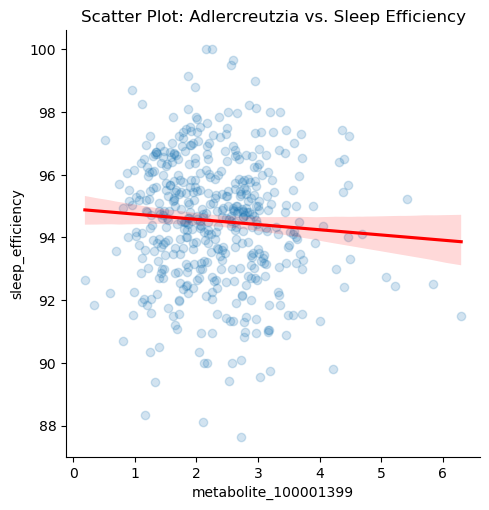

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, and you want to plot each column against "sleep_efficiency"
g = sns.lmplot(x='metabolite_100001399', y='sleep_efficiency', data=moreCafSleep, scatter_kws={'alpha':0.2}, ci=95, fit_reg=True, line_kws={'color': 'red'})
plt.title(f'Scatter Plot: Adlercreutzia vs. Sleep Efficiency')
#plt.ylim([0,5])
plt.show()

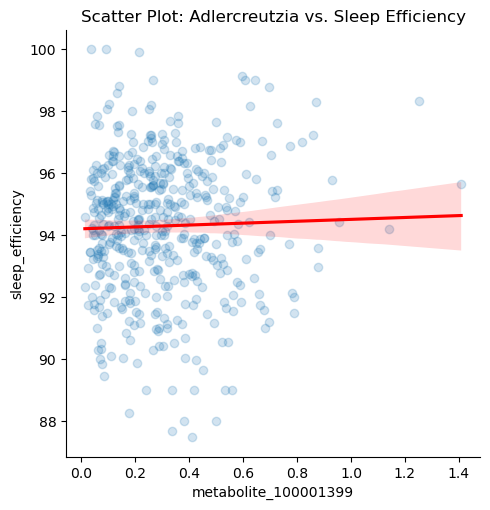

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, and you want to plot each column against "sleep_efficiency"
g = sns.lmplot(x='metabolite_100001399', y='sleep_efficiency', data=lessCafSleep, scatter_kws={'alpha':0.2}, ci=95, fit_reg=True, line_kws={'color': 'red'})
plt.title(f'Scatter Plot: Adlercreutzia vs. Sleep Efficiency')
#plt.ylim([0,5])
#plt.ylim([4.45,4.6])
plt.show()

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

df = sleep_merged.copy()
df.dropna(subset=metabolite, how='all')

# Assuming df is your DataFrame, and you want to plot each column against "sleep_efficiency"
g = sns.lmplot(x='metabolite_100001399', y='sleep_efficiency', data=df, scatter_kws={'alpha':0.2}, ci=95, fit_reg=True, line_kws={'color': 'red'}, y_partial=df[sleep_features])
plt.title(f'Scatter Plot: Adlercreutzia vs. Sleep Efficiency')
#plt.ylim([0,5])
#plt.ylim([4.45,4.6])
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

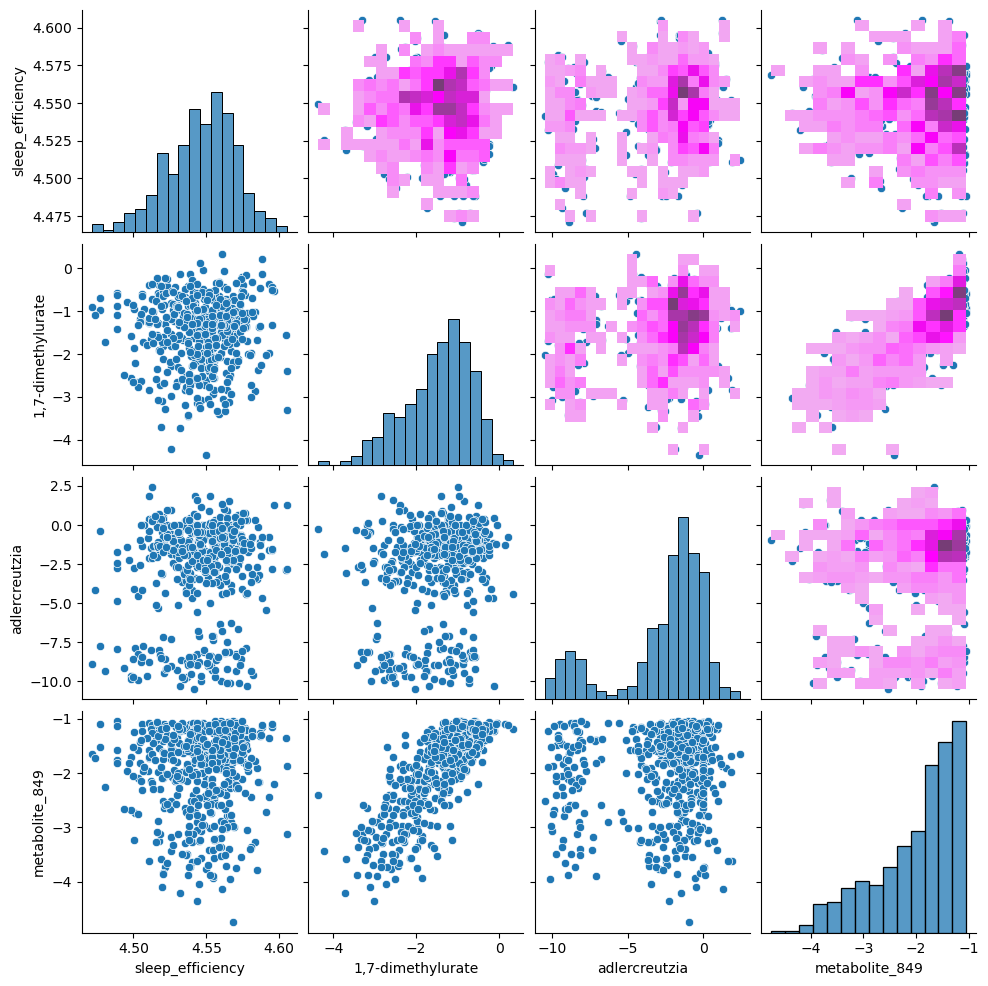

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

df = lessCafSleep.copy()
df = df.rename(columns={'metabolite_100001399': '1,7-dimethylurate', 'bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia' : 'adlercreutzia'})
features = ['sleep_efficiency', '1,7-dimethylurate', 'adlercreutzia', 'metabolite_849']

g = sns.pairplot(df[features])
g.map_upper(sns.histplot, color='purple')
plt.show()

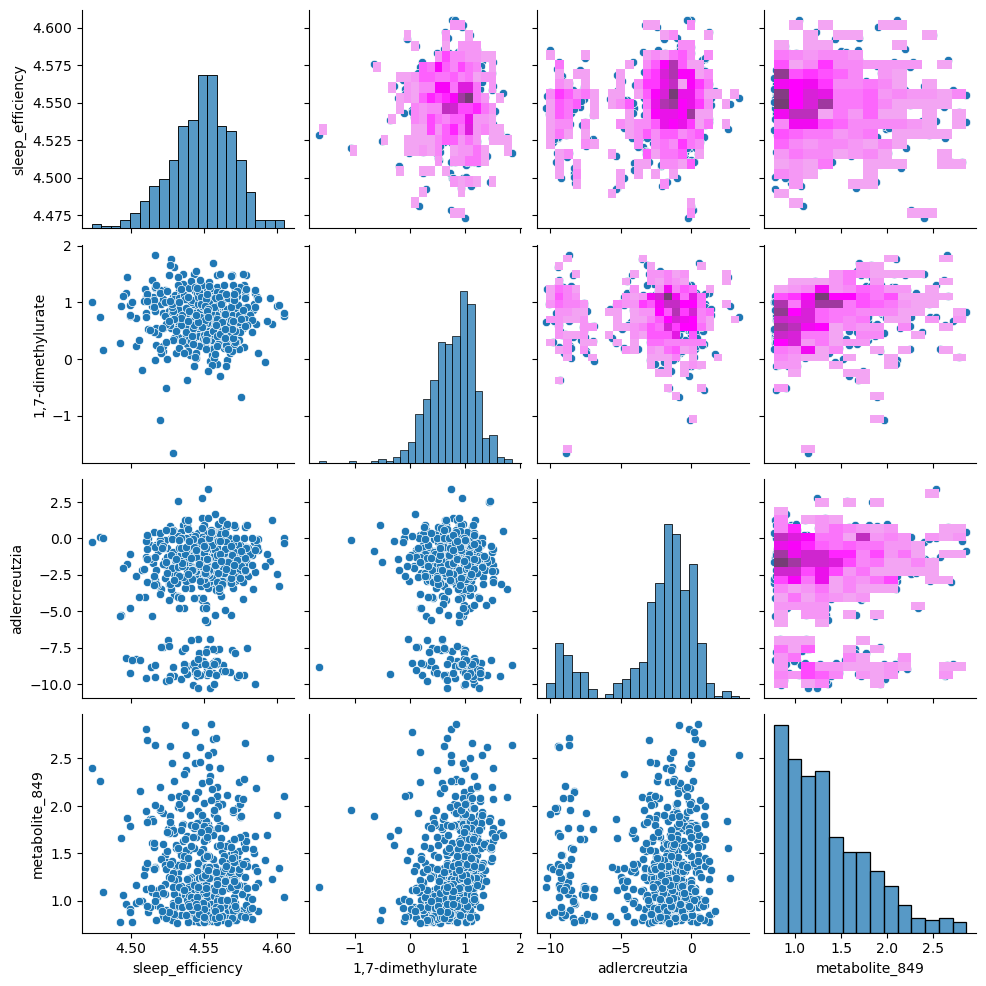

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

df = moreCafSleep.copy()
df = df.rename(columns={'metabolite_100001399': '1,7-dimethylurate', 'bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia' : 'adlercreutzia'})
features = ['sleep_efficiency', '1,7-dimethylurate', 'adlercreutzia', 'metabolite_849']

g = sns.pairplot(df[features])
g.map_upper(sns.histplot, color='purple')
plt.show()

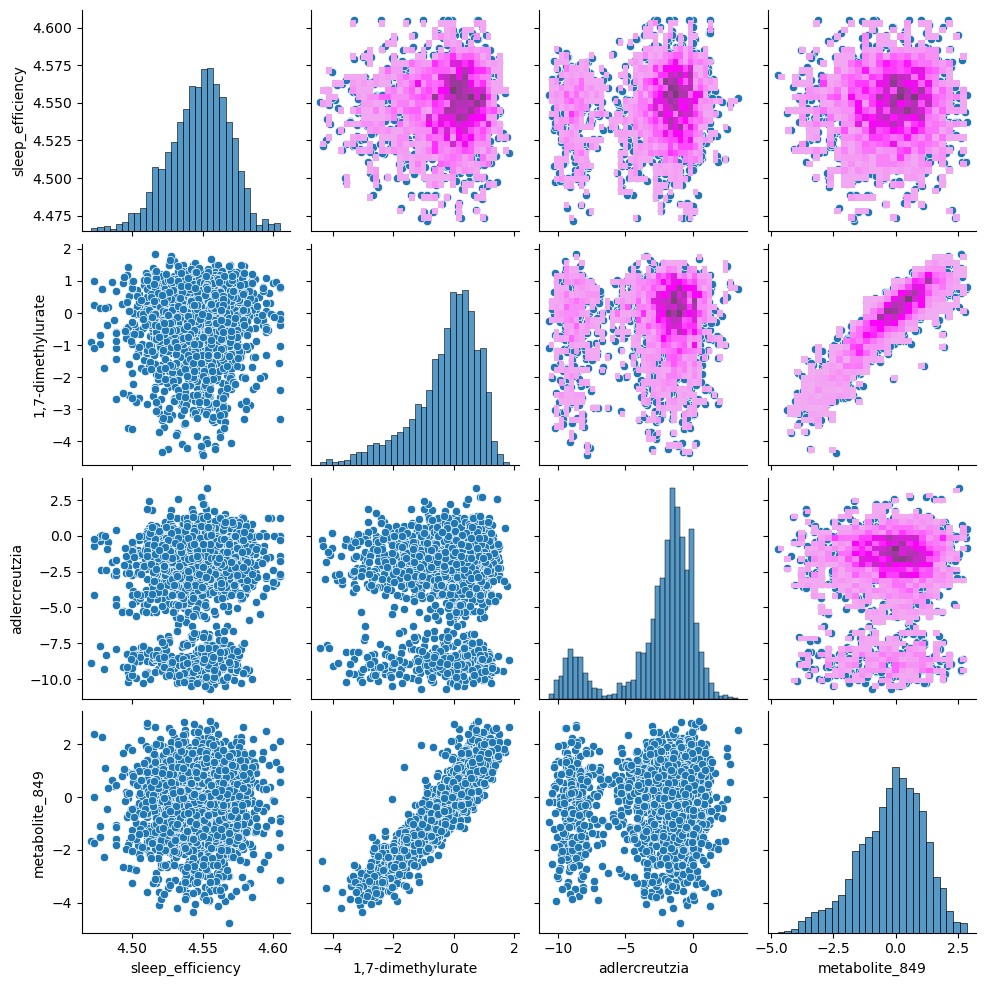

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

df = sleep_merged.copy()
df = df.rename(columns={'metabolite_100001399': '1,7-dimethylurate', 'bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia' : 'adlercreutzia'})
features = ['sleep_efficiency', '1,7-dimethylurate', 'adlercreutzia', 'metabolite_849']

g = sns.pairplot(df[features])
g.map_upper(sns.histplot, color='purple')
plt.show()

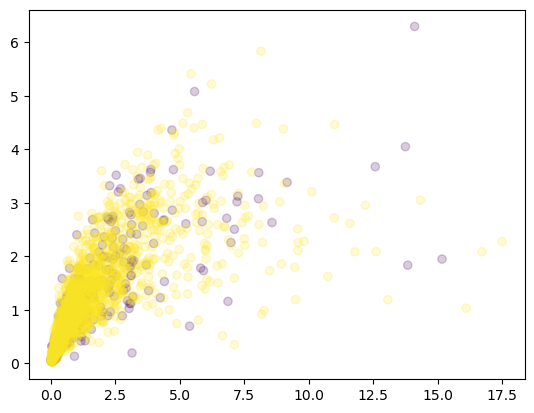

In [30]:
#cmap = sns.diverging_palette(as_cmap=True, h_neg=20, h_pos=300)


f, ax = plt.subplots()
points = ax.scatter(data=sleep_merged.sort_values(by='adlercreutzia_binary'), x='metabolite_849', y='metabolite_100001399', c='adlercreutzia_binary', alpha=0.2)
#f.colorbar(points)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


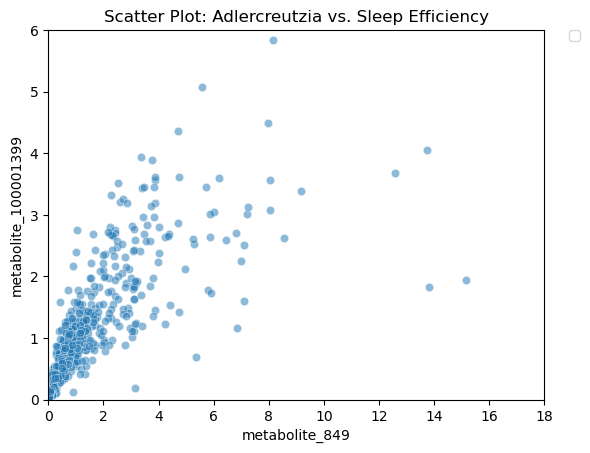

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, and you want to plot each column against "sleep_efficiency"
sns.scatterplot(x='metabolite_849', y='metabolite_100001399', data=lessAdler, alpha=0.5)
plt.title(f'Scatter Plot: Adlercreutzia vs. Sleep Efficiency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylim([0,6])
plt.xlim([0,18])
#plt.ylim([4.45,4.6])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


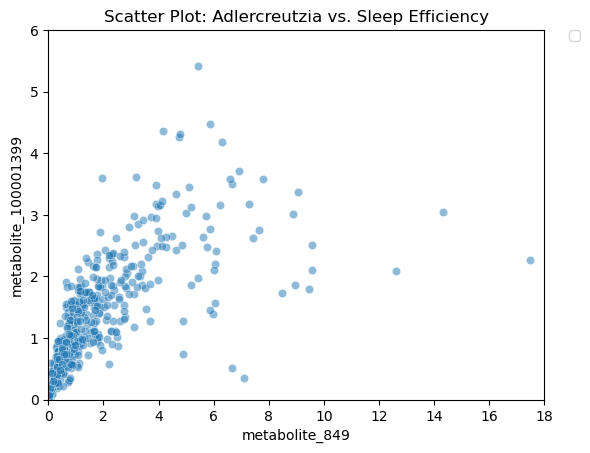

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, and you want to plot each column against "sleep_efficiency"
sns.scatterplot(x='metabolite_849', y='metabolite_100001399', data=moreAdler, alpha=0.5)
plt.title(f'Scatter Plot: Adlercreutzia vs. Sleep Efficiency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylim([0,6])
plt.xlim([0,18])
#plt.ylim([4.45,4.6])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


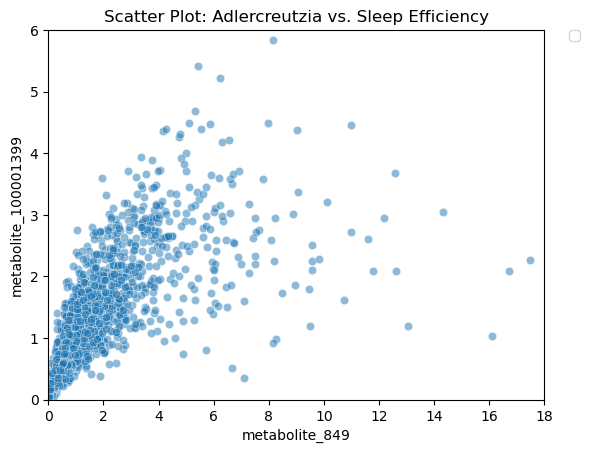

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, and you want to plot each column against "sleep_efficiency"
sns.scatterplot(x='metabolite_849', y='metabolite_100001399', data=sleep_merged[sleep_merged.adlercreutzia_binary == 1], alpha=0.5)
plt.title(f'Scatter Plot: Adlercreutzia vs. Sleep Efficiency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylim([0,6])
plt.xlim([0,18])
#plt.ylim([4.45,4.6])
plt.show()

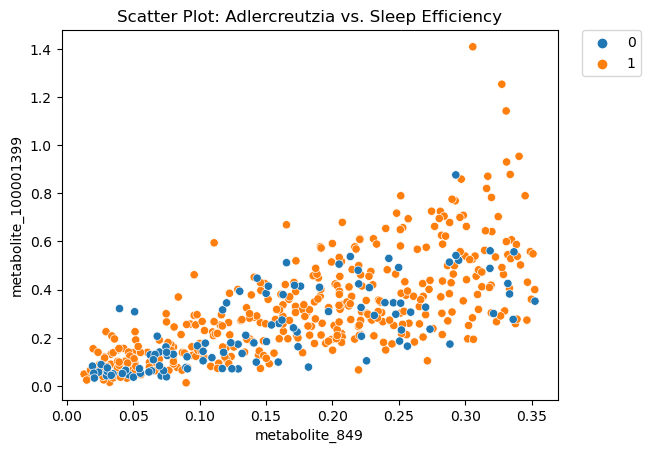

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, and you want to plot each column against "sleep_efficiency"
sns.scatterplot(x='metabolite_849', y='metabolite_100001399', data=lessCafSleep.sort_values(by='adlercreutzia_binary', ascending=False), hue='adlercreutzia_binary', alpha=1)
plt.title(f'Scatter Plot: Adlercreutzia vs. Sleep Efficiency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#plt.ylim([0,1.5])
#plt.xlim([0,18])
#plt.ylim([4.45,4.6])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


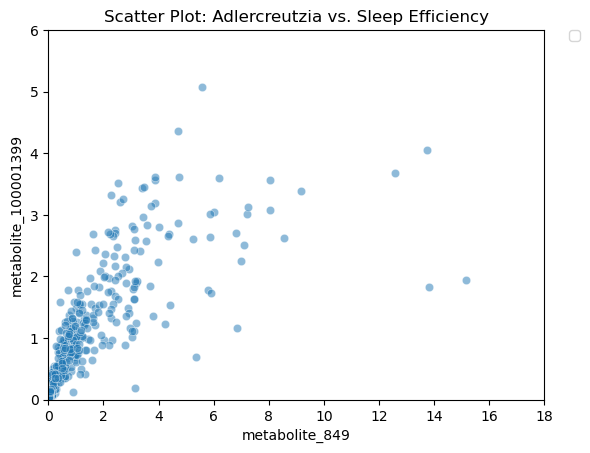

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame, and you want to plot each column against "sleep_efficiency"
sns.scatterplot(x='metabolite_849', y='metabolite_100001399', data=sleep_merged[sleep_merged.adlercreutzia_binary == 0], alpha=0.5)
plt.title(f'Scatter Plot: Adlercreutzia vs. Sleep Efficiency')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.ylim([0,6])
plt.xlim([0,18])
#plt.ylim([4.45,4.6])
plt.show()

In [63]:
df = sleep_merged.copy()
df['low_caffeine'] = df['metabolite_849'].apply(lambda x: True if x < -1.041699 else False)
df.dropna(subset=['low_caffeine', 'bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia', 'sleep_efficiency'], inplace=True)

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia", y="sleep_efficiency", hue='low_caffeine', alpha=0.2)

NameError: name 'df' is not defined

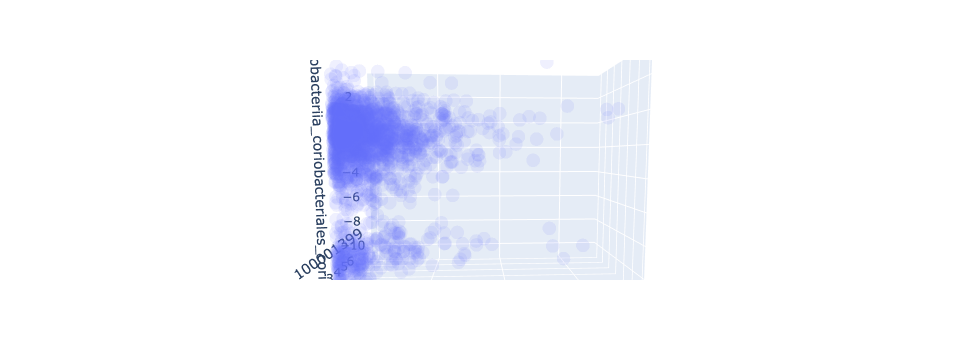

In [20]:
#sns.scatter3D(data=sleep_merged, x="bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia", y="sleep_efficiency", z="metabolite_849")
import plotly.express as px

g=px.scatter_3d(data_frame=sleep_merged, z="bacteria_actinobacteria_coriobacteriia_coriobacteriales_coriobacteriaceae_adlercreutzia", x="metabolite_849", y="metabolite_100001399", opacity=0.1)
g.show()